In [6]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")
    
# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple___Apple_scab ...
[INFO] Processing Apple___Black_rot ...
[INFO] Processing Apple___Cedar_apple_rust ...
[INFO] Processing Apple___healthy ...
[INFO] Processing background ...
[INFO] Processing Blueberry___healthy ...
[INFO] Processing Cherry_(including_sour)___healthy ...
[INFO] Processing Cherry_(including_sour)___Powdery_mildew ...
[INFO] Processing Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot ...
[INFO] Processing Corn_(maize)___Common_rust_ ...
[INFO] Processing Corn_(maize)___healthy ...
[INFO] Processing Corn_(maize)___Northern_Leaf_Blight ...
[INFO] Processing Grape___Black_rot ...
[INFO] Processing Grape___Esca_(Black_Measles) ...
[INFO] Processing Grape___healthy ...
[INFO] Processing Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_spot ...
[INFO] Processing Peach___healthy ...
[INFO] Processing Pepper,_bell___Bacterial_spot 

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


In [11]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [6]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [7]:
EPOCHS = 50
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [8]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [12]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...


C:\Users\Ayushi\AppData\Local\Temp\ipykernel_4684\3670682867.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),


Epoch 1/50
97/97 [==============================] - 374s 4s/step - loss: 0.5653 - accuracy: 0.0495 - val_loss: 0.1521 - val_accuracy: 0.0526
Epoch 2/50
97/97 [==============================] - 354s 4s/step - loss: 0.1616 - accuracy: 0.1383 - val_loss: 0.1755 - val_accuracy: 0.0231
Epoch 3/50
97/97 [==============================] - 378s 4s/step - loss: 0.1145 - accuracy: 0.2568 - val_loss: 0.1915 - val_accuracy: 0.0218
Epoch 4/50
97/97 [==============================] - 352s 4s/step - loss: 0.0996 - accuracy: 0.3455 - val_loss: 0.2479 - val_accuracy: 0.0231
Epoch 5/50
97/97 [==============================] - 348s 4s/step - loss: 0.0923 - accuracy: 0.4012 - val_loss: 0.1033 - val_accuracy: 0.2269
Epoch 6/50
97/97 [==============================] - 403s 4s/step - loss: 0.0810 - accuracy: 0.4683 - val_loss: 0.1231 - val_accuracy: 0.1962
Epoch 7/50
97/97 [==============================] - 473s 5s/step - loss: 0.0724 - accuracy: 0.5347 - val_loss: 0.1567 - val_accuracy: 0.1295
Epoch 8/50
97

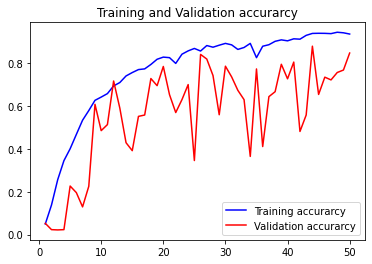

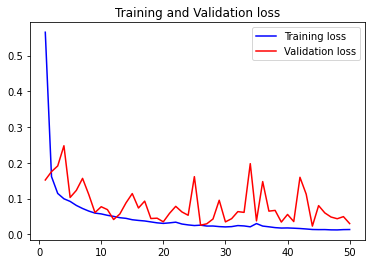

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [14]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
25/25 [==============================] - 18s 679ms/step - loss: 0.0302 - accuracy: 0.8487
Test Accuracy: 84.87179279327393


In [15]:
# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://5f0ca1e7-fe75-4a8b-8b97-995e2fb1295e/assets


In [16]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


In [18]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = np.argmax(model.predict(np_image), axis=-1)
    print((image_labels.classes_[result][0]))

In [3]:
predict_disease('./PlantVillage/val/Blueberry___healthy/008c85d0-a954-4127-bd26-861dc8a1e6ff___RS_HL 2431.JPG')

NameError: name 'predict_disease' is not defined

In [2]:
predict_disease('./PlantVillage/val/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

NameError: name 'predict_disease' is not defined

In [7]:
# Load model
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://42b31ea2-fa29-43d6-9fa7-584231d974d3/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [5]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

ImportError: cannot import name 'BatchNormalization' from 'keras.layers.normalization' (C:\Users\Ayushi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\normalization\__init__.py)